Import Data
---

In [1]:
import pandas as pd # Loadind Data
import matplotlib.pyplot as plt  # To visualize
df = pd.read_csv("CleanDataBase.csv")
df.head()

,ID,GroupNum,Height,Weight,Age,Male,RightLeg,AdaptationDuration,Abrupt,MidSpeed,...,OGBase,OGAfter,IsCatch,Stroke,TextSpeedRatio,BMI,Young,TMSteadyGood,TMSteadyPositive,TMAfterGood
0,B001,1,160.0,60.9,20.0,0,1,604,1,1100,...,-0.159450,-0.159450,1,0,2.0,23.789062,1,1,0,1
1,B003,1,174.0,68.0,20.0,0,1,602,1,1100,...,0.005824,0.005824,1,0,2.0,22.460034,1,1,0,1
2,B004,1,159.0,59.2,20.0,1,1,603,1,1000,...,0.057757,0.057757,1,0,2.0,23.416795,1,0,0,1
3,BC001,1,160.0,60.9,20.0,0,1,601,1,1100,...,-0.029394,-0.029394,1,0,2.0,23.789062,1,1,0,1
4,BC004,1,165.0,65.0,20.0,1,1,600,1,1100,...,-0.008461,-0.008461,1,0,2.0,23.875115,1,0,0,1


Steady State Features and Targets
---

In [2]:
from patsy import dmatrices

Y, X = dmatrices('TMSteadyGood ~ EarlyA + MidBase + AdaptationDuration + Height + SpeedDifference + Age + \
    AdaptationDuration*Age + Age*Height + EarlyA*AdaptationDuration + EarlyA*Height + EarlyA*MidBase + \
    EarlyA*Weight + Height*Weight + MidBase*AdaptationDuration + \
    MidBase*Age + MidSpeed*AdaptationDuration + MidSpeed*Height + Weight*BMI + \
    SpeedDifference*EarlyA*AdaptationDuration + MidSpeed*C(Abrupt)*C(Young) + C(Abrupt)*C(Young)*C(IsCatch) + \
    C(Young)*C(IsCatch)*C(Stroke)', df, return_type="dataframe")

df_Interactions = pd.concat([X,Y], axis=1)

In [3]:
# "FULL" Model Predicted from Random Forrest
feature_cols = ['EarlyA', 'MidBase', 'AdaptationDuration', 'Height', 'SpeedDifference', 'Age', \
               'AdaptationDuration:Age', 'EarlyA:MidBase', 'Age:Height', 'EarlyA:AdaptationDuration', \
               'EarlyA:Height','MidSpeed:AdaptationDuration', 'Weight:BMI', 'EarlyA:Weight', \
                'Height:Weight', 'MidBase:AdaptationDuration', 'MidBase:Age', 'MidSpeed:Height', \
               'SpeedDifference:EarlyA:AdaptationDuration', 'MidSpeed:C(Abrupt)[T.1]:C(Young)[T.1]', \
               'C(Abrupt)[T.1]:C(Young)[T.1]:C(IsCatch)[T.1]', 'C(Young)[T.1]:C(IsCatch)[T.1]:C(Stroke)[T.1]']

target_cols = "TMSteadyGood"

If we did not use the features selected from the Random Forrrest, we would have selected the following features:

feature_cols=["SpeedRatio", "SpeedDifference","MidSpeed", "Abrupt", "EarlyA", "MidBase", \
               "AdaptationDuration", "Age", "Young", "Height", "Weight", "BMI",\
             'IsCatch', 'Stroke']

target_cols = "TMSteadyPositive"
df_Interactions = df

Split data into training and testing sets
---

In [4]:
Features = df_Interactions[feature_cols]
Target = df_Interactions[target_cols]

In [5]:
import numpy as np
np.random.seed(37)

# Split data into training and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(Features,Target,test_size = 0.2)

y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

Up-Sampling
---
My TMSteadyGood target is reasonably well dispersed between 'good' and 'bad' adapters.

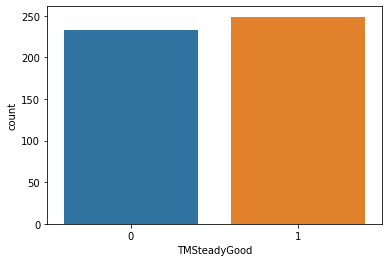

In [6]:
import seaborn as sns # Also to visualize
sns.countplot(x = target_cols, data = df)
plt.show()

In [7]:
# From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = feature_cols)

In [8]:
X_train = os_data_X
y_train = os_data_y

Mass Modeling
---

In [9]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
AdaBoostClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

clfs = {'DT':   DecisionTreeClassifier(max_depth = 4),
        'RFC':  RandomForestClassifier(max_depth = 4),
        'ET':   ExtraTreesClassifier(n_estimators = 10, n_jobs = -1, criterion = 'entropy'),
        'LR':   LogisticRegression(max_iter = 9000),
        'SGD':  SGDClassifier(loss = 'log'),
        'GB':   GradientBoostingClassifier(learning_rate = 0.05, subsample = 0.5, max_depth = 6, n_estimators = 10),
        'NB':   GaussianNB(),
        'KNN':  KNeighborsClassifier(1),
        'SVC1': SVC(kernel = "linear", C = 0.025),
        'SVC2': SVC(gamma = 2, C = 1),
        'GPC':  GaussianProcessClassifier(1.0 * RBF(1.0)),
        'MLP':  MLPClassifier(alpha = 1, max_iter = 1000),
        'ABC':  AdaBoostClassifier(),
        'QDA':  QuadraticDiscriminantAnalysis()}

In [10]:
sel_clfs = [ 'DT', 'ET', 'RFC', 'LR', 'SGD','GB', 'NB', 'KNN', 'GPC',  'MLP', 'ABC', 'QDA',  'SVC1', 'SVC2']

Initialize plotting functions:

In [11]:
calc_threshold = lambda x,y: 0 if x < y else 1 

In [12]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt  # To visualize

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

In [13]:
from sklearn.metrics import accuracy_score

def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])

        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
        
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('% Predicted > Each Thresholds')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf() 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Recall Baseline: 1.0 Test: 0.73
Precision Baseline: 0.58 Test: 0.69
Accuracy Baseline: 0.5 Test: 0.66
Confusion matrix, without normalization


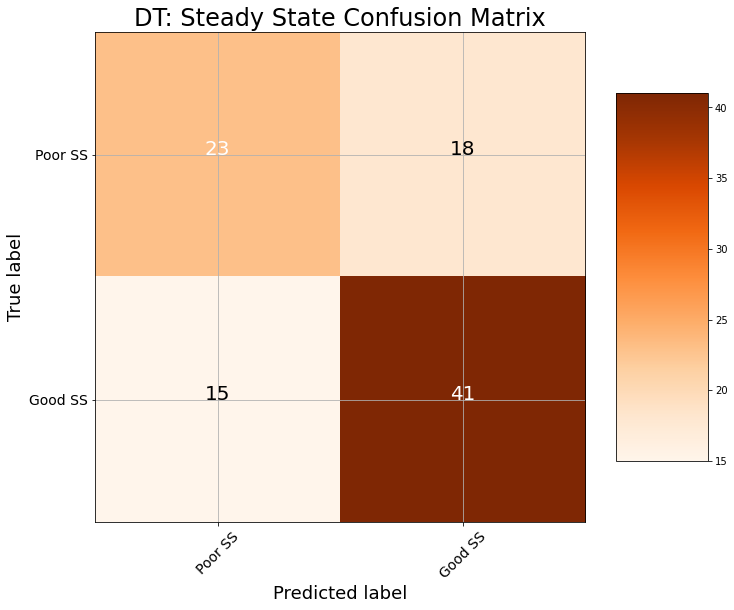

0.6382978723404256


<Figure size 432x288 with 0 Axes>

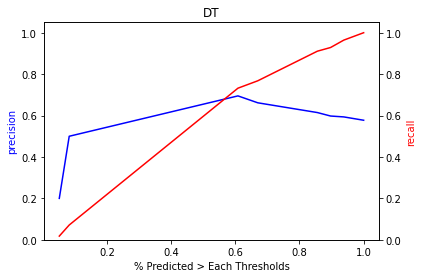

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Recall Baseline: 1.0 Test: 0.5
Precision Baseline: 0.58 Test: 0.67
Accuracy Baseline: 0.5 Test: 0.57
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

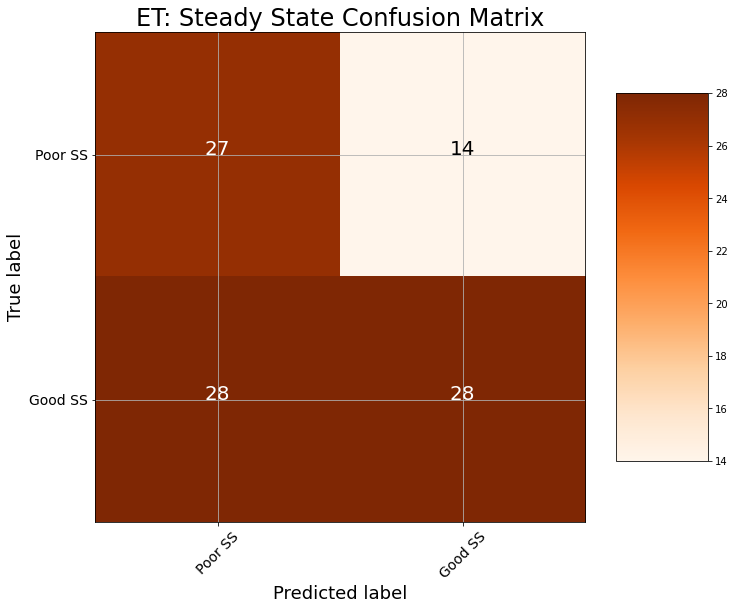

0.5


<Figure size 432x288 with 0 Axes>

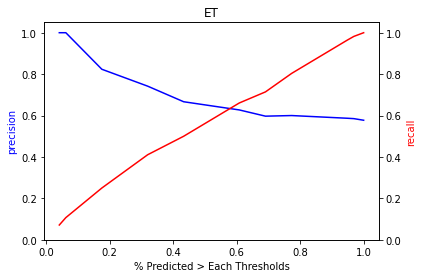

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall Baseline: 1.0 Test: 0.57
Precision Baseline: 0.58 Test: 0.68
Accuracy Baseline: 0.5 Test: 0.6
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

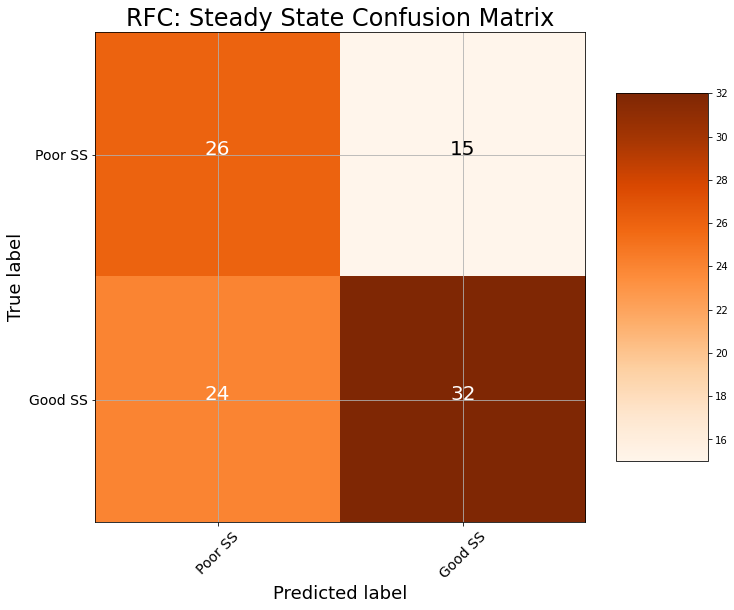

0.6029979562106828


<Figure size 432x288 with 0 Axes>

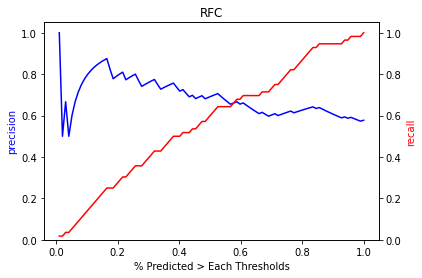

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recall Baseline: 1.0 Test: 0.62
Precision Baseline: 0.58 Test: 0.74
Accuracy Baseline: 0.5 Test: 0.66
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

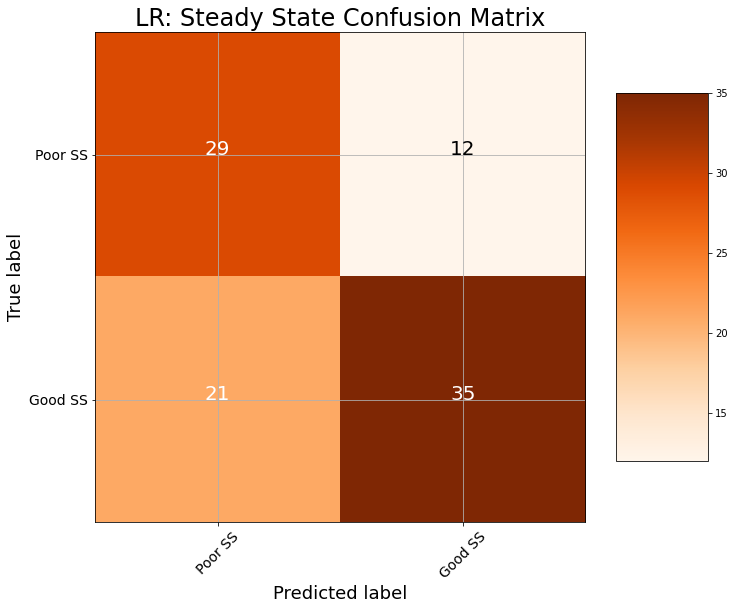

0.3708745633973292


<Figure size 432x288 with 0 Axes>

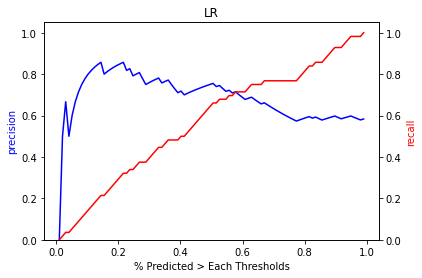

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Recall Baseline: 1.0 Test: 0.0
Precision Baseline: 0.58 Test: 0.0
Accuracy Baseline: 0.5 Test: 0.42
Confusion matrix, without normalization


/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

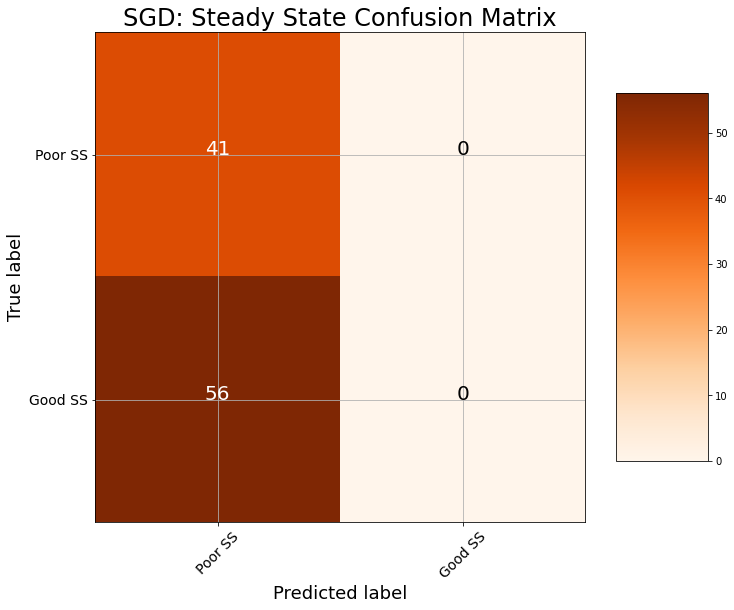

0.0


<Figure size 432x288 with 0 Axes>

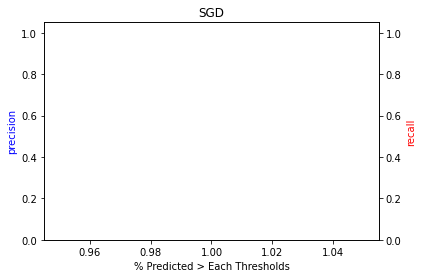

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Recall Baseline: 1.0 Test: 0.7
Precision Baseline: 0.58 Test: 0.7
Accuracy Baseline: 0.5 Test: 0.65
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

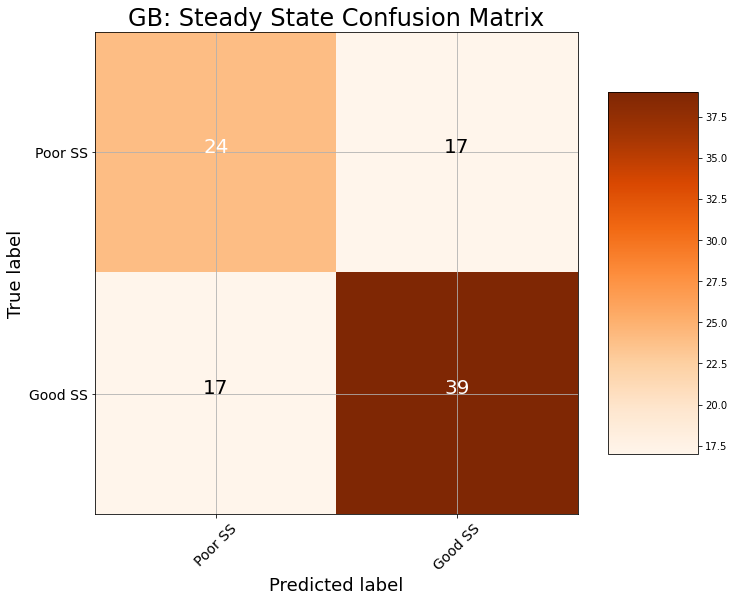

0.6076129596466314


<Figure size 432x288 with 0 Axes>

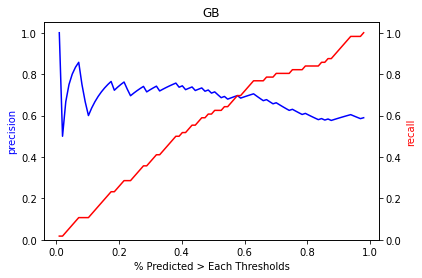

GaussianNB(priors=None, var_smoothing=1e-09)
Recall Baseline: 1.0 Test: 0.62
Precision Baseline: 0.58 Test: 0.78
Accuracy Baseline: 0.5 Test: 0.68
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

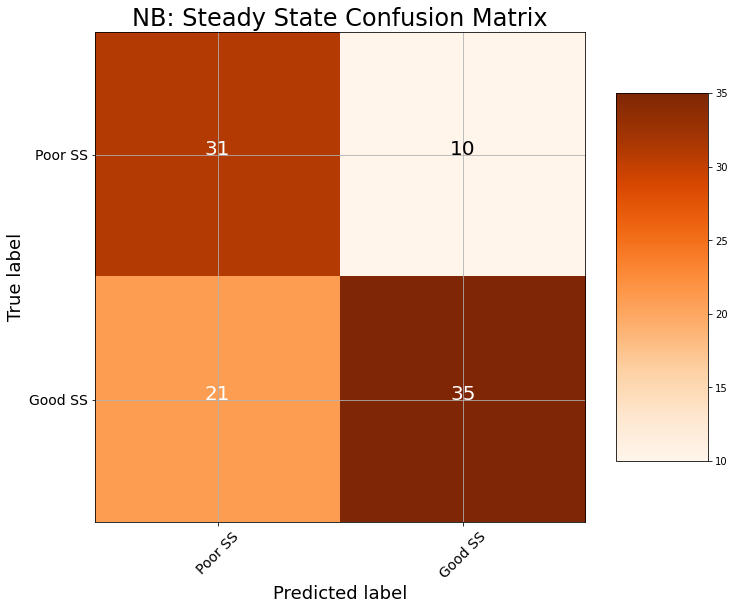

0.4956837425740966


<Figure size 432x288 with 0 Axes>

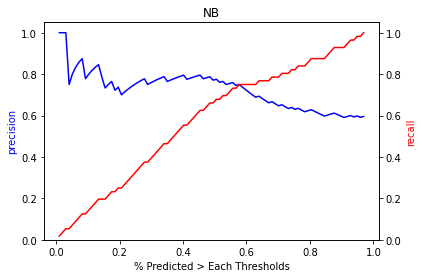

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')
Recall Baseline: 1.0 Test: 0.57
Precision Baseline: 0.58 Test: 0.68
Accuracy Baseline: 0.5 Test: 0.6
Confusion matrix, without normalization


<Figure size 432x288 with 0 Axes>

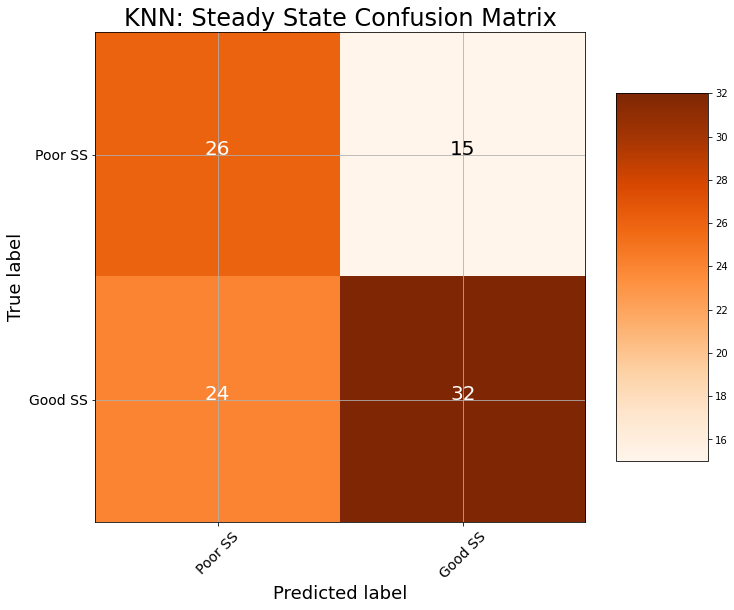

GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)


/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Baseline: 1.0 Test: 0.0
Precision Baseline: 0.58 Test: 0.0
Accuracy Baseline: 0.5 Test: 0.42
Confusion matrix, without normalization


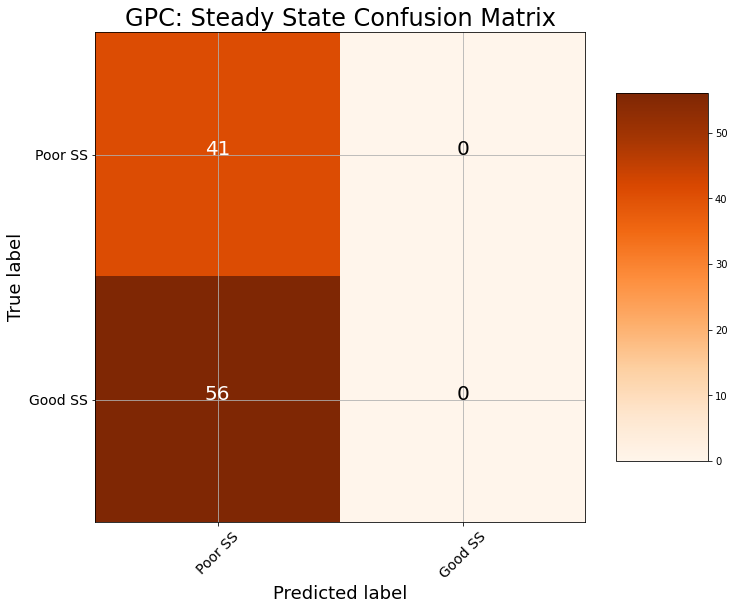

0.49999999500016656


<Figure size 432x288 with 0 Axes>

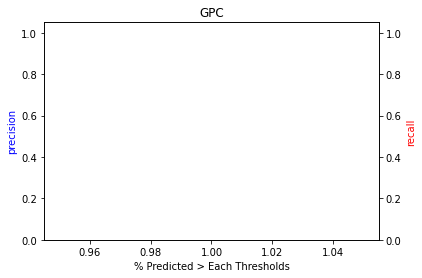

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Recall Baseline: 1.0 Test: 0.86
Precision Baseline: 0.58 Test: 0.66
Accuracy Baseline: 0.5 Test: 0.66
Confusion matrix, without normalization


/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


<Figure size 432x288 with 0 Axes>

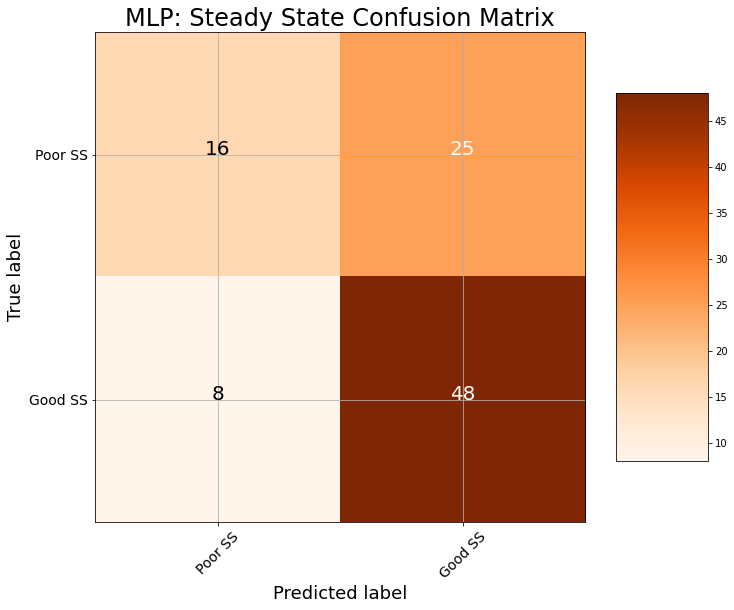

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Recall Baseline: 1.0 Test: 0.62
Precision Baseline: 0.58 Test: 0.71
Accuracy Baseline: 0.5 Test: 0.64
Confusion matrix, without normalization


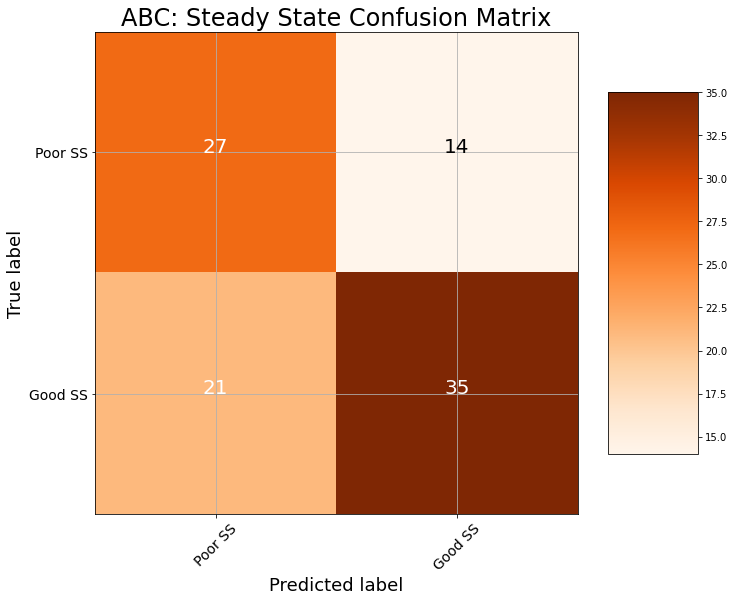

0.5045597704788024


<Figure size 432x288 with 0 Axes>

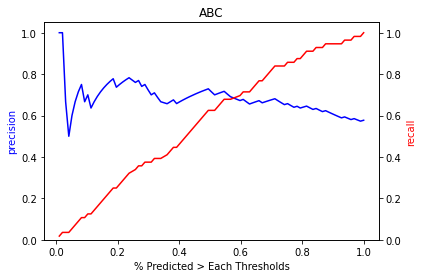

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)
Recall Baseline: 1.0 Test: 0.0
Precision Baseline: 0.58 Test: 0.0
Accuracy Baseline: 0.5 Test: 0.42
Confusion matrix, without normalization


/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:718: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/carlysombric/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:715: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/carlysombric/anaconda3/lib/python3.6/site-packages/s

<Figure size 432x288 with 0 Axes>

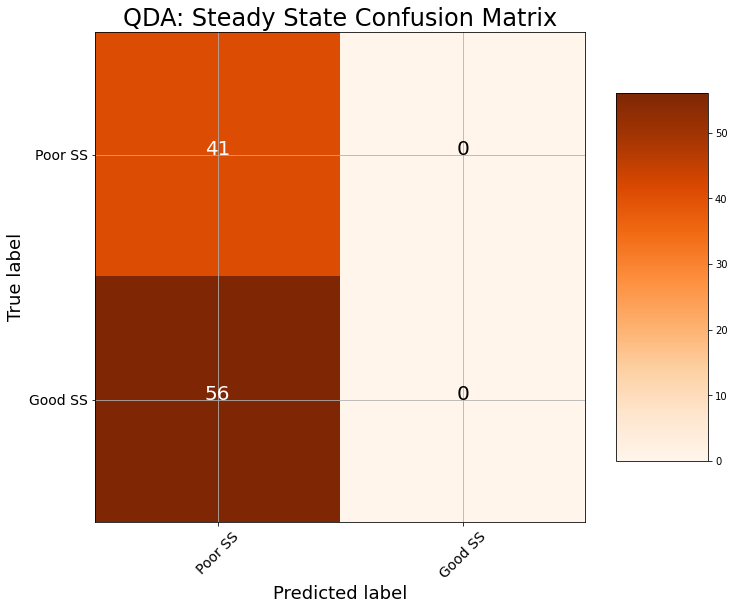

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Recall Baseline: 1.0 Test: 0.61
Precision Baseline: 0.58 Test: 0.69
Accuracy Baseline: 0.5 Test: 0.62
Confusion matrix, without normalization


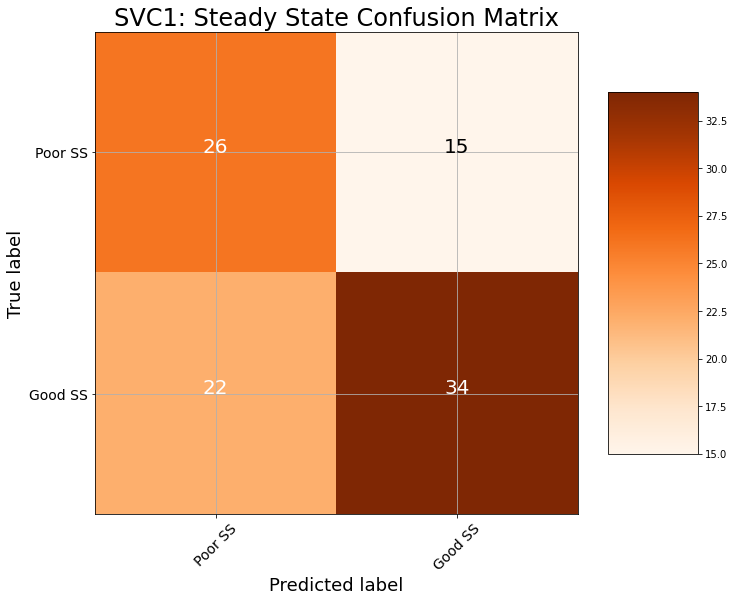

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Recall Baseline: 1.0 Test: 1.0
Precision Baseline: 0.58 Test: 0.58
Accuracy Baseline: 0.5 Test: 0.58
Confusion matrix, without normalization


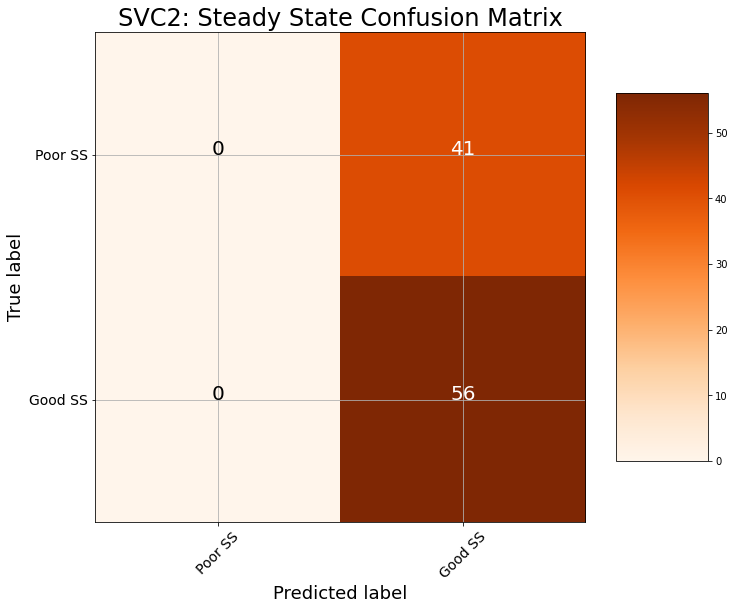

In [14]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, precision_recall_curve
import math

for clfNM in sel_clfs:
    clf = clfs[clfNM]
    print(clf)
    clf.fit( X_train, y_train )
    predicted = clf.predict(X_test)
    expected = np.array(y_test)
    
    try:
        y_score = clf.predict_proba(X_test)[:,1]  
        predicted_prob = np.array(y_score)
    except AttributeError:
        y_score[1] = 10000
    
    # Evaluation: Recall, Precision, and Accuracy
    baseline = {}
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    baseline['accuracy'] = 0.5
    
    results = {}
    results['recall'] = recall_score(y_test, predicted)
    results['precision'] = precision_score(y_test, predicted)
    results['accuracy'] = accuracy_score(y_test, predicted)
    #results['roc'] = roc_auc_score(test_labels, probs)
    
    for metric in ['recall', 'precision', 'accuracy']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)}')
    
    # Evaluation: Visualize Confusion Matrix
    plot_confusion_matrix(confusion_matrix(expected, predicted),
                        classes = ['Poor SS', 'Good SS'],
                      title = clfNM + ': Steady State Confusion Matrix')

    # Evaluation: Precision Recall Curves
    if (np.isnan(y_score[1]) != True) & (y_score[1] < 1 ):
        print(y_score[1])
        plot_precision_recall_n(expected, predicted_prob, clfNM)

In Conclusion...
---

In conclusion, the steady states (i.e., "TMSteadyGood") are able to be **classified with Recall, Precision, and Accuracy scores greater than 0.65**.  In particular, the Decision Tree, SGD, and MLP classifiers seems to perform consistently.